# Assignment 4 – Finding the way out in a maze

*Due: Friday January 27 at 17:00 CET*

In the forth assignment of the course Applications of Machine Learning (INFOB3APML), you will learn to use RL algorithms to solve the practical problem of ‘robot in a maze’. The objectives of this assignment are:
- learn to formalize a practical problem into the Markov Decision Process (MDP)
- get familier with the OpenAI gym framework (recently renamed as Gymnasium) and use it to implement RL agents
- use the SARSA and Q-learning algorithm to solve the ‘robot in a maze’ MDP problem
- evaluate the results of reinforcement learning and interpret your findings
- reflect on the difference between two type of RL algorithms

In this assignment, you are going to develop a robot and find its way out in a maze. The project is divided into three parts (5 subtask):
-	In the first part (1), you will get familier with the OpenAI gym/gymnasium framework. 
-	In the second part, based on the gym/gymnasium framework, we have implemented the environment for you (2.1). Your task is to formalize the problem as a MDP model (2.0), implement your own RL agents (2.2) and to train them for finding the shortest route to get out of a maze (2.3).
-	In the third part (3), you will evaluate and interpret your results from the implemented RL agents.


## 1. Let's start with the OpenAI gym

Gym/Gynasium (https://gymnasium.farama.org/) is a wide-used standard toolkit for developing and comparing reinforcement learning algorithms. Gynasium is the maintained fork of OpenAI’s Gym library (more story about this recent change if you are interested: https://farama.org/Announcing-The-Farama-Foundation).

1. Gym/Gynasium makes no assumptions about the structure of your agent, and is compatible with any numerical computation library, such as TensorFlow or Theano. 

2. The library is a collection of test problems — **environments** — that you can use to work out your reinforcement learning algorithms. These environments have a shared interface, allowing you to write general algorithms.

First, we download & install the gym/gynasium library. Then import the gymnasium class.

In [1]:
!pip install gymnasium



We are now going to explain how the RL framework of gym works. 
- An **ENVIRONMENT**, 
- You also have an **AGENT**,
- In MDP problems (like ours), the **ENVIRONMENT** will also provides an **OBSERVATION**, which represets the state of the **ENVIRONMENT** at the current moment.
- The agent takes an **ACTION** based on its **OBSERVATION**,
- When a single **ACTION** is chosen and fed to our **ENVIRONMENT**, the **ENVIRONMENT** measures how good the action was taken and produces a **REWARD**, which is usually a numeric value.

Please read the 'Basic usage' https://gymnasium.farama.org/content/basic_usage/ for better understanding the framework.  And do not forget import gymnasium before running other codes.

In [2]:
import gymnasium as gym

 ## 2. Go back to our own task
 
 Next, you will solve a practical MDP problem 'robot in a maze' based on the gym framework. You shall implement the RL agent and train it to find the shortest route to achieve the maze goal. In this MDP, the enviroment is a grid world (a maze) while the agent is a robot. At each time step, the robot starts at a random location and can move around in the grid world. The long-term objective is finding the way out (reaching the final location). Hence, you need to find a fixed goal position within the maze.

### 2.0 Model the practical task into a MDP

To solve a RL problem, we start with formalizing the problem into a MDP model. Please describe this MDP model in your report. 

Notice: No empricial data provided in this assignment, so the point of 'data description and exploration' will be given to this step. 

While exploring your MDP model, you shall think about questions such as:
- What is the environment? How does it look like?
- What simulated data can your RL agent observe from the environment? How does it look like?
- Which data is considered as the state? Which data is considered as the reward?

### 2.1 Set up the environment

There is no need to implement your own environment. You shall use the environment we provide in the file **environment.py**. But please make sure to have a look at it, so that you understand the inner working of this environment.

The core gym interface is **Env**, which is the unified environment interface. The following are the Env methods you should know:

- reset(self): Reset the environment's state. Returns observation.
- step(self, action): Step the environment by one timestep. Returns observation, reward, done, info. 
- render(self, mode='rgb_array'): Render one frame of the environment. The default mode will do something human friendly, such as pop up a window. In this assignment, there is no need to create a pop up window. 

Please notice that you need to first install the [mazelab](https://github.com/zuoxingdong/mazelab) package for running the environment (a file with required packages is also given). If you run the below cell the first time. Make sure to restart the ipython notebook at least once.

In [3]:
!git clone https://github.com/sw1989/mazelab.git
!pip install -e mazelab
!pip install pandas
!pip install seaborn

fatal: destination path 'mazelab' already exists and is not an empty directory.


Obtaining file:///C:/Users/jeroe/OneDrive/Documenten/GItHub/APML/opdracht4/apml-assignment-4-broam/mazelab
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Attempting uninstall: mazelab
    Found existing installation: mazelab 0.2.0
    Uninstalling mazelab-0.2.0:
      Successfully uninstalled mazelab-0.2.0
  Running setup.py develop for mazelab


You can now check whether the required packages (e.g. mazela, pandas, tqdm, seaborn) are installed. Please install the ones are missing. 

ATTENTION: To run the given code, please use the python version 3.7-3.9, and the numpy version < 1.23

We also provide a few helper functions to make it easier to debug your agents. 
 - `animate_run` will enable you to see the agent's behavior. It takes a list of images which can be produced by the `env.render` function of the environment
 - `visualize_agent_brain` will provide you with a way to visualize the agents learned q_table. Use it after you have implemented and trained your agents. The first plot will show the highest q-value per state (position on the map) and the second will tell you which action the agent would choose at that state/position. It takes the environment and the agent as input.

Below you will find a basic example of how the animation function works. Please notice that: whenever you **reset()** the environment, the agent will start at a random position (a different state). 

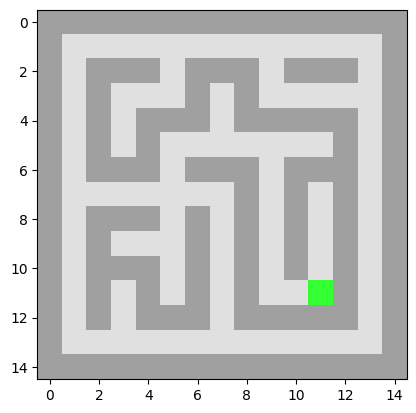

In [4]:
# The helper functions

from IPython import get_ipython
import random
from mazelab.generators import random_maze, morris_water_maze
import matplotlib.pyplot as plt
from IPython import display
from mazelab.solvers import dijkstra_solver
import seaborn as sns
from tqdm.notebook import tqdm
from environment import TaskEnv
from typing import Tuple, List
import itertools as it
import numpy as np
import pandas as pd


def animate_run(data:List[np.ndarray]):
    init_img = data[0]
    remaining_img = data[1:]
    img_container = plt.imshow(init_img)  # only call this once
    for img in remaining_img:
        img_container.set_data(img)  # just update the data
        display.display(plt.gcf())
        display.clear_output(wait=True)


def visualize_agent_brain(agent, env: TaskEnv):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    ax1.set_title("Highest state value at position (x,y)")
    state_value_map = agent.q_table.max(axis=2)
    sns.heatmap(state_value_map, ax=ax1)

    ax2.set_title("Chosen action at position (x,y)")
    n = env.action_space.n + 1
    path = env.maze.objects.free.positions
    decisions_map = np.array([[x_, y_, agent.select_action([x_, y_]) + 1] for x_, y_ in path])
    state_action_map = np.zeros_like(agent.q_table.max(axis=2))
    state_action_map[decisions_map[:, 0], decisions_map[:, 1]] = decisions_map[:, 2]
    cmap = sns.color_palette("viridis", n)
    sns.heatmap(state_action_map, cmap=cmap, ax=ax2)
    colorbar = ax2.collections[0].colorbar
    r = (colorbar.vmax) - colorbar.vmin
    colorbar.set_ticks([colorbar.vmin + r / n * (0.5 + i) for i in range(n)])
    colorbar.set_ticklabels(['N/A', 'north', 'south', 'west', 'east'])
    fig.tight_layout()
    return plt.show()


env = TaskEnv()
env.reset()
impassable_array = env.unwrapped.maze.to_impassable()
motions = env.unwrapped.motions
start = env.unwrapped.maze.objects.agent.positions[0]
goal = env.unwrapped.maze.objects.goal.positions[0]
actions = dijkstra_solver(impassable_array, motions, start, goal)
print(actions)

imgs = []
rewards = 0.0
for action in actions:
    _, reward, _, _ = env.step(action)
    rewards += reward
    imgs.append(env.render("rgb_array"))
print(rewards)

animate_run(imgs)
plt.show()

### 2.2  Implement the agents 

In this part, you are expected to implement two RL agents. 

- Agent 1 uses the Q-learning algorithm to learn the optimal solution
- Agent 2 uses the SARSA algorithm to learn the optimal solution. To decide the action to take at each time step,  this agent uses the epsilon greedy action selection.

Here we also provided an example agent: Random Agent. It follows a random policy to move at each step (randomly select the action). You can use this example agent as a baseline to evaluate your agents.


In [5]:
# Random agent
class RandomAgent():
    def __init__(self,
                 env: TaskEnv,
                 exploration_rate: float = None,
                 learning_rate: float = None,
                 discount_factor: float = None) -> int:
        self.epsilon = 1  # A random agent "explores" always, so epsilon will be 1
        self.alpha = 0  # A random agent never learns, so there's no need for a learning rate
        self.gamma = 0  # A random agent does not update it's q-table. Hence, it's zero.
        self.q_table = np.zeros(env.observation_space.shape + (env.action_space.n, ), dtype=float)
        self.actions = env.action_space

    def select_action(self, state: Tuple[int, int], use_greedy_strategy: bool = False) -> int:
        if not use_greedy_strategy:
            if random.random() < self.epsilon:
                next_action = self.actions.sample()
                return next_action

        x, y = state
        max_val = np.max(self.q_table[x, y, :])
        find_max_val = np.where(self.q_table[x, y, :] == max_val)
        next_action = np.random.choice(find_max_val[0])
        return next_action

    def learn(self, state, action, next_state, reward, done):
        return None


In [6]:
class QLearningAgent():
    def __init__(self,
                 env: TaskEnv,
                 exploration_rate: float = 0.1,
                 learning_rate: float = 0.8,
                 discount_factor: float = 0.95) -> int:
        self.epsilon = exploration_rate
        self.alpha = learning_rate
        self.gamma = discount_factor
        self.q_table = np.zeros(env.observation_space.shape + (env.action_space.n, ), dtype=float)
        self.actions = env.action_space

    def select_action(self, state: Tuple[int, int], use_greedy_strategy: bool = False) -> int:
        if not use_greedy_strategy:
            if random.random() < self.epsilon:
                next_action = self.actions.sample()
                return next_action

        x, y = state
        max_val = np.max(self.q_table[x, y, :])
        find_max_val = np.where(self.q_table[x, y, :] == max_val)
        next_action = np.random.choice(find_max_val[0])
        return next_action

    def learn(self, state, action, next_state, reward, done):
        x, y = state
        x_, y_ = next_state
        max_val = np.max(self.q_table[x_, y_, :])
        self.q_table[x, y, action] = (1 - self.alpha) * self.q_table[x, y, action] + self.alpha * (reward + self.gamma * max_val)

In [14]:
class SarsaAgent():
    def __init__(self,
                 env: TaskEnv,
                 exploration_rate: float = 0.6,
                 learning_rate: float = 0.5,
                 discount_factor: float = 0) -> int:
        self.epsilon = exploration_rate 
        self.alpha = learning_rate  
        self.gamma = discount_factor  
        self.q_table = np.zeros(env.observation_space.shape + (env.action_space.n, ), dtype=float)
        self.actions = env.action_space

    def select_action(self, state: Tuple[int, int], use_greedy_strategy: bool = False) -> int:
        if not use_greedy_strategy:
            if random.random() < self.epsilon:
                next_action = self.actions.sample()
                return next_action

        x, y = state
        max_val = np.max(self.q_table[x, y, :])
        find_max_val = np.where(self.q_table[x, y, :] == max_val)
        next_action = np.random.choice(find_max_val[0])
        return next_action

    def learn(self, state, action, next_state, reward, done): 
        x, y = state
        x_, y_ = next_state
        next_action = self.select_action(next_state)
        predict = self.q_table[x, y, action] 
        target = reward + self.gamma * self.q_table[x_, y_, next_action] 
        self.q_table[x, y, action] = self.q_table[x, y, action] + self.alpha * (target - predict)

        


### 2.3 Run the simulation

Now, we write the codes for running a simulation. In each run, you shall setup the epsilon parameter. 

In [8]:

def run_sim(agent, env, num_episodes = 15000):

    imgs = []
    total_rewards = 0.0
    success_episodes = 0
    env.reset()
    imgs.append(env.render("rgb_array"))
    for i in range(num_episodes):
        rewards = 0.0
        state = env.reset()
        done = False

        while not done:
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)
            agent.learn(state, action, next_state, reward, done)
            state = next_state
            rewards += reward
            time_out+=1
            

            

            if done:
                success_episodes += 1
        
        total_rewards += rewards
    animate_run(imgs)
    visualize_agent_brain(agent=agent, env=env)    
    average_reward = total_rewards / num_episodes
    success_rate = success_episodes / num_episodes


    print("Average reward per episode: ", average_reward)
    print("Success rate: ", success_rate)

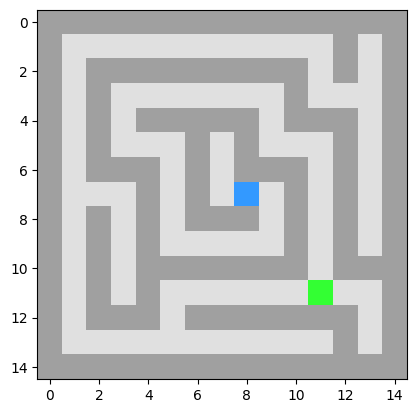

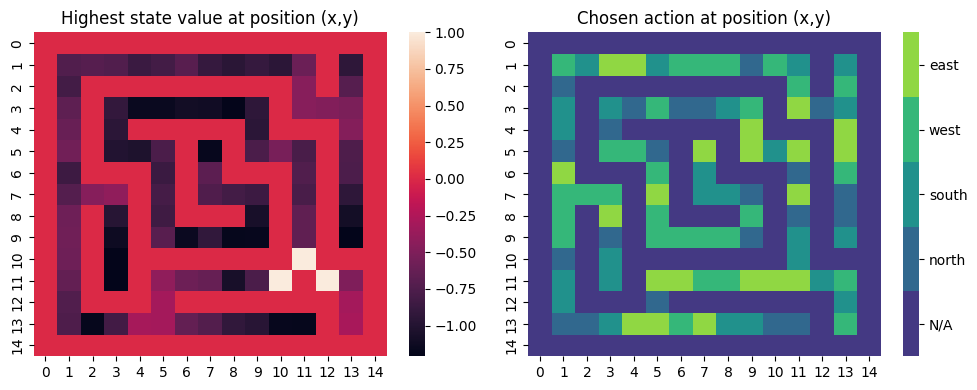

Average reward per episode:  -69.8639673333335
Success rate:  1.0


In [15]:
env = TaskEnv()
Qagent = QLearningAgent(env, exploration_rate=1, learning_rate=0.5, discount_factor=0.3)
Sagent = SarsaAgent(env, exploration_rate=1, learning_rate=0.5, discount_factor=0.3)

run_sim(Qagent, env)
run_sim(Sagent, env)

 ## 3. Play with parameters and analyse results
 
Finally, you will describe, evaluate and interpret your results from two RL agents, as well as compare your agents with the given Random agent. Feel free to use the provided helper functions for evaluating your agents. Some points are good to notice:

- Both quantified evaluation and human evaluation are needed in the report. The quantified evaluation shall focus on the measurement of reward. In human evaluation, you can use the provided visual tools to interpret your results. Your report shall include at least one plot presenting comparable measures of the different agents. 

- While evaluating the results of Agent 2 (with SARSA algorithm), please try at least 2 different values of **epsilon** (expect 0) and discuss the influence of different epsilon values on results. In the end, please identify a reasonable epsilon value that could balance the exploration and exploitation, then fix this value for comparing two agents. Present your trails and results in the report.

- In the report, you also need to parcitularly describe and discuss the similarity and difference of results from two RL agents (hint: on-policy VS off-policy). For this, please make sure that the compared results are obtained from the same environment (a same maze for two different agents). Also, while evaluating the results of two agents, please try at least 2 different values of **gamma**. In this way, you could discuss the influence of this discount factor in your report. 

- Please run the simulation for multiple times and average them for all your results. 


In [10]:
# TODO: evaluation 


# Bonus Tasks 

We would like to challenge you with the following bonus task. For each task that is successfully completed, you may obtain max. 1 extra point. 

1. Implement a third RL agent using another RL algorithm (e.g. Monte Carlo methods, Expected SARSA or even neural network-based ones) and discuss your findings. Compare this third agent with the above ones and explain why this is a better (or worse) RL algorithm. You are allowed to reuse exsiting packages, but please cite them, test them in advance, and make sure that you can explain the used algorithm using your own words.

2. Can you explore and show other evaluation results? If so, implement and present one extra result (e.g. a plot). And please explain why it is a good evaluation for our task or how it shows the difference between two RL agents/algorithms.